  # Hand Written Digit Recognition from MNIST dataset using Convolutional Neural Networks(CNN)

* We will load the training and testing images from MNIST first.
* Then display them on to a grid so that we can have a chance to witness the vareity of digits in each class.
* After that we'll need to prepare our data for training by reshaping it into specific format and then normalizing it.
* Then we start training the data. "Remember that the training data set is used to train the neural network to obtain the approriate parameters."

In [1]:
# Imports
# Make sure to install tensorflow and keras, if you are running in local system. If your using google colab no need to install anything just run the code
# Sequential allows to define nueral model
# Dense allows us to connect preceeding layers in the network to subsequent layers creating a fully connected layer network
# Adam optimizer as we are dealing with multi-class classification. So we must use one hot encodeing too
# to_categorical for One hot encoding. Required for multi-class classification

import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense  
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
import random

In [2]:
# To get same data whenever called

np.random.seed(0)

In [3]:
# importing training data to obtain the parameters and test data to evaluate the performance of the neural network.
# mnist.load_data imports 60000 images with labels into training data and 10000 images into testing data.
# Each image in the dataset is 28px wide and 28px height i.e each image has 784 pixels.

(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
# (dataset size, width, height) is the output

print(X_train.shape)
print(X_test.shape)
print(y_train.shape[0]) # no.of labels

(60000, 28, 28)
(10000, 28, 28)
60000


In [5]:
# assert func takes in a single argument, the argument is just a condition that is either True or False.
# If the condition is true then the code runs smoothly otherwise print a string
# Using this func is a good practice as it helps debug a complex problem
# NOTE: The no.of training images must be equal to the no.of labels for consistency

# Conditions to be satisfied:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (28,28)), "The dimensions of the images are not 28x28"
assert(X_test.shape[1:] == (28,28)), "The dimensions of the images are not 28x28"

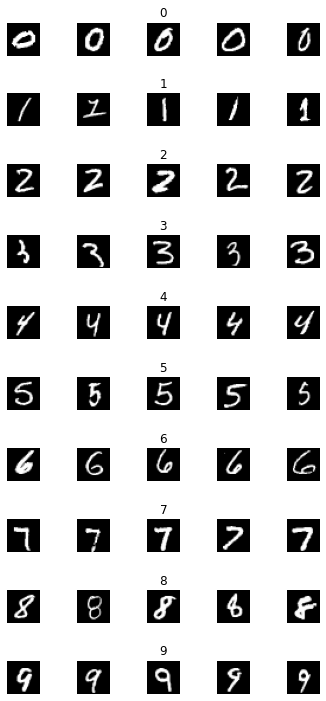

In [6]:
# Visulalize the no.of images in each class (from 0 to 9)

# array to record no.of images in each of our ten categories
num_of_samples = []

# we'll create a grid arrangement to help us visualize. Our grid will contain 10 rows, 0 to 9, in each row we'll have 5 columns of images
cols = 5
num_classes = 10

# subplots allow you to display multiple plots on the same figure. It also returns tuples which contains 2 values, an instance of our figure and plot axis.
fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 10))
fig.tight_layout()  # To avoid overlapping of plots

# We are going to loop through every single column and for each column iteration we will iterate through every row or in this case every class we do this by creating a nested for loop arrangement that cycles through our data and counts it up.
for i in range(cols):
    for j in range(num_classes):
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray')) # random images from the dataset are shown to see how different the digits are in the same class.
        axs[j][i].axis("off") # To remove axis
#         Adding titles to each row like 0,1,2,3,....,9
        if i == 2:
            axs[j][i].set_title(str(j))
            num_of_samples.append(len(x_selected))

No.of Samples: [5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]


Text(0, 0.5, 'Number of images')

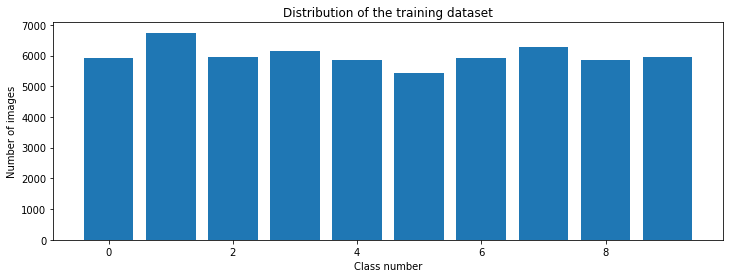

In [7]:
print("No.of Samples:", num_of_samples) # shows the no.of images belonging to each class

# Lets visualize this with bar plots
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

# Preparing our data to use it in training

### NOTE: 
- Previously, we flattened our image to give it as input, but here we are leaving the image as it is, that is 28*28 also add a depth of 1.
 With regular Neural Networks the image had to be flattened into a 1-d array of pixel intensities. 
- For CNN its different. First we add a depth, Why depth?, as CNN works by applying filter to the channels of the image that are being viewed, in case of gray-scale images there is one channel present, therefore our data must reflect the presence of the depth.
- By adding this depth of 1 our data will be in the desired shape to be used as an input for the convolutional layer.


In [8]:
# adding depth

X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)

In [9]:

# First perform One hot encoding on train and test data, which is necessary for multi class classification.
y_train = to_categorical(y_train, 10) # (labels to encode, total no.of classes)
y_test = to_categorical(y_test, 10)

In [10]:
# Normalize the data
# We choose to divide by 255 because we want to normalize our data to be in a range between 0 and 1.
# This ensures that the max pixel value 255 is normalized down to the max value of 1.
# This normalization process is important as it scales down our features to a uniform range and decreases variance among our data. We need to ensure that our data has low variance. Helps to learn more clearly and accurately.

X_train = X_train/255 
X_test = X_test/255

# Creating the model
- There are predefined CNN Architectures like LeNet, AlexNet, ZFNet, GoogleNet etc
- We will be designing a LeNet based architecture for digit recognition
> LeNet model contains 2 convolutional layers and 2 pooling layers

## We will be using dropout layer to reduce overfitting
- This layer functions by randomly setting a fraction rate of input units to 0 at each update during training, which helps prevent overitting. This process is implemented only on training data not on testing or new data. So while using new data all nodes are utilzed to provide a more efficient result.
- we will be using only 1 dropout layer. However, more than one dropout layer can be used to increase the performance.
- Remember that these layers are mostly placed inbetween the layers that have a high number of parameters because the high parameter layers are more likely to overfit.
- Dropout rate is the amount of input nodes the dropout layers drops during each update. where 0 indicates to drop 0 nodes and 1 indicates to drop all nodes, 0.5 is the recommended rate.

In [11]:
from keras.layers import Flatten      # To flatten our data
from keras.layers.convolutional import Conv2D  # for Convolutional layers
from keras.layers.convolutional import MaxPooling2D # for pooling layers
from keras.layers import Dropout
from keras.models import Model

In [12]:
# points:
# 1. Convolution layer with 30 filters, play around by changing no.of filters. Each filter will have a 5*5 format of prameter values. input shape of 28*28 with depth of 1 and activation function used is relu. Stride is the number of increments the kernel shifts, by default stride=1 if not mentioned. Smaller stride retains more info as more convolutional operations are performed. Padding  is used preserve the spacial dimentionality of the image but we are not using padding for the mnist dataset.
# 2. Pooling layer of size 2*2. Therefore grabbing a max value in a feature map within a 2*2 neighborhood. After pooling process the shape of our convoluted image is going to go from a 24*24*30 to a smaller shape of 12*12*30 because maxpooling scales down every feature map into a smaller abstracted representation.
# 3. Since we are dealing with a more dense input for this layer we're going to use fewer filters,i.e, 15 filters with each filter of size 3 by 3. Parameters increases demanding more computational power.
# Flatten allows us to flatten our data inorder to format it properly for it to go in the fully connected network
# 4. Flatten layer will take our output data with a shape of 5 by 5 by 15 and reshape it into a 1D array, you can see that in the below output.
# 5. Fully Conencted layer is added using Dense wit no.of nodes = 500, this number can be adjusted as desired, a lower number can provide minimally less accuracy while higher number requires high computational power.
# Dropout rate is the amount of input nodes the dropout layers drops during each update. where 0 indicates to drop 0 nodes and 1 indicates to drop all nodes, 0.5 is the recommended rate.

# define LeNet func
def leNet_model():
  model = Sequential()
  model.add(Conv2D(30, (5, 5), input_shape=(28, 28, 1), activation='relu')) # Note 1
  model.add(MaxPooling2D(pool_size=(2,2))) # Note 2
  model.add(Conv2D(15, (3, 3), activation='relu')) # Note 3
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())  # Note 4
  model.add(Dense(500, activation='relu')) # Note 5
  model.add(Dropout(0.5)) # Have a look at the plots below and comment this dropout layer to see the change in the plots.
  model.add(Dense(num_classes, activation='softmax'))  # output layer with no.of nodes = no.of classes.
  model.compile(Adam(learning_rate=0.01), loss="categorical_crossentropy", metrics=["accuracy"])
  return model

In [13]:
# Seeing the summary gives us an overview of our Convolutional model

model = leNet_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 30)        780       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 30)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 15)        4065      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 15)          0         
_________________________________________________________________
flatten (Flatten)            (None, 375)               0         
_________________________________________________________________
dense (Dense)                (None, 500)               188000    
_________________________________________________________________
dropout (Dropout)            (None, 500)               0

## Note: We split our training data into training and validation sets.
- where training set is used to tune the weights and bias
- validation set is used to tune the hyper parameters.

> When ever the validation error is more than training error that indicates the start of our model overfitting

In [14]:
# Train the model usiing model.fit. Remember that model.fit gives the history
# Verbose to display the progress

history = model.fit(X_train, y_train, epochs = 10, validation_split=0.1, batch_size=400, verbose=1, shuffle=1)

Epoch 1/10
135/135 [==============================] - 16s 11ms/step - loss: 0.6339 - accuracy: 0.7906 - val_loss: 0.0557 - val_accuracy: 0.9823
Epoch 2/10
135/135 [==============================] - 1s 7ms/step - loss: 0.0761 - accuracy: 0.9761 - val_loss: 0.0548 - val_accuracy: 0.9847
Epoch 3/10
135/135 [==============================] - 1s 7ms/step - loss: 0.0648 - accuracy: 0.9797 - val_loss: 0.0419 - val_accuracy: 0.9888
Epoch 4/10
135/135 [==============================] - 1s 7ms/step - loss: 0.0513 - accuracy: 0.9838 - val_loss: 0.0374 - val_accuracy: 0.9892
Epoch 5/10
135/135 [==============================] - 1s 7ms/step - loss: 0.0512 - accuracy: 0.9843 - val_loss: 0.0342 - val_accuracy: 0.9900
Epoch 6/10
135/135 [==============================] - 1s 7ms/step - loss: 0.0403 - accuracy: 0.9873 - val_loss: 0.0356 - val_accuracy: 0.9908
Epoch 7/10
135/135 [==============================] - 1s 7ms/step - loss: 0.0391 - accuracy: 0.9873 - val_loss: 0.0382 - val_accuracy: 0.9897
Epoc

Text(0.5, 0, 'epoch')

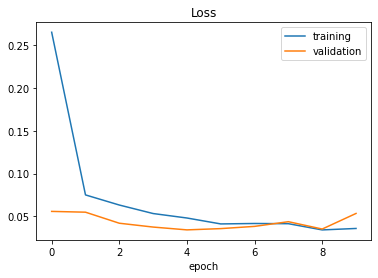

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

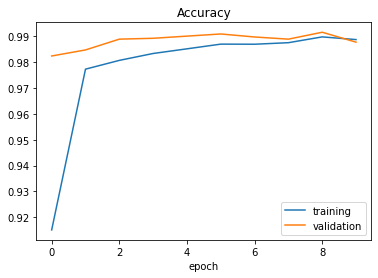

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

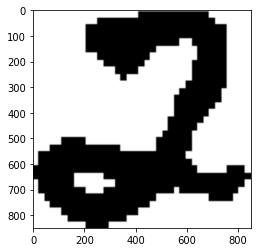

In [17]:
# Testing our model on new external image
# url for number 2 https://www.researchgate.net/profile/Jose_Sempere/publication/221258631/figure/fig1/AS:305526891139075@1449854695342/Handwritten-digit-2.png

import requests
from PIL import Image

url = 'https://www.researchgate.net/profile/Jose_Sempere/publication/221258631/figure/fig1/AS:305526891139075@1449854695342/Handwritten-digit-2.png'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

resized image shape: (28, 28, 4)
Grayscale image shape: (28, 28)


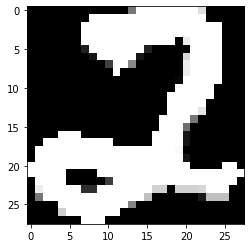

In [18]:
# We need to make the above image into numpy array so that we can modify the image into a 28*28 image which is the required input.
# our neural netwrok is trained on 28*28 image with black background and white pixels. So we convert the above image into required format.
import cv2

array_img = np.asarray(img)
resized_img = cv2.resize(array_img, (28, 28))
print("resized image shape:", resized_img.shape)
gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
print("Grayscale image shape:", gray_img.shape)
image = cv2.bitwise_not(gray_img)
plt.imshow(image, cmap=plt.get_cmap('gray'))

In [19]:
image = image/255
image = image.reshape(1, 28, 28, 1)

In [20]:
prediction = np.argmax(model.predict(image), axis=-1)
print("predicted digit:", str(prediction))

predicted digit: [2]


In [21]:
# Testing data

score = model.evaluate(X_test, y_test, verbose=0)
print(type(score))
print('Test score:', score[0])
print('Test accuracy:', score[1])

<class 'list'>
Test score: 0.050614792853593826
Test accuracy: 0.9873999953269958


In [22]:
# To visualize what happens in convolutional layers using model class API

# we will be seeing what our convolutional layers are seeing when they process the image.
# model.layers[0] to access the first convolutional layer, .input gives the input passed to that layer and .output give outputs from theat layer
# model.layers[2] to access the 2nd convolutional layer which is at index 2 in model.layers

layer1 = Model(inputs=model.layers[0].input, outputs=model.layers[0].output)
layer2 = Model(inputs=model.layers[0].input, outputs=model.layers[2].output)

# run a prediciton
visual_layer1, visual_layer2 = layer1.predict(image), layer2.predict(image)
print(visual_layer1.shape) # indicates 30 outputs one for each filter of 24 by 24 dimention
print(visual_layer2.shape) # indicates 15 outputs one for each filter of 10 by 10 dimention

(1, 24, 24, 30)
(1, 10, 10, 15)


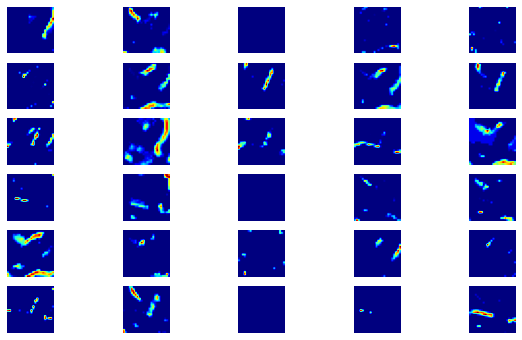

In [23]:
plt.figure(figsize=(10, 6))
# for 30 filters
for i in range(30):
  plt.subplot(6, 5, i+1) # 6 rows 5 cols
  plt.imshow(visual_layer1[0, :, :, i], cmap = plt.get_cmap('jet'))
  plt.axis('off')
# we can see various features extracted by 30 filters in Convolutional layer 1

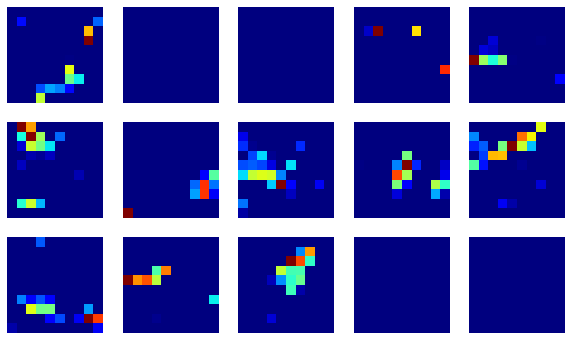

In [24]:
plt.figure(figsize=(10, 6))
# for 15 filters
for i in range(15):
  plt.subplot(3, 5, i+1) # 3 rows 5 cols
  plt.imshow(visual_layer2[0, :, :, i], cmap = plt.get_cmap('jet'))
  plt.axis('off')
# we can see various features extracted by 15 filters in Convolutional layer 2